This notebook contains the code to reproduce part of Supplementary Figure 1 from the manuscript M. D. Luecken, and F. J. Theis "Best practices in single-cell RNA-seq: a tutorial".

In [5]:
import scanpy.api as sc
import numpy as np
import scipy as sp
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from maren_codes import combat as c
from gprofiler import gprofiler

import warnings
from rpy2.rinterface import RRuntimeWarning
from rpy2.robjects import pandas2ri


%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# Load the data

The data is obtained from Klein et al., 2015 via the GEO code GSE65525 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE65525). It contains mouse embryonic stem cells.

In [7]:
# Set up data loading

#Data files
file1 = '../data/Klein15/GSM1599494_ES_d0_main.csv' 
file2 = '../data/Klein15/GSM1599495_ES_d0_biorep_techrep1.csv' 

In [8]:
adata = sc.read(file1, cache=True)
adata = adata.transpose()
adata.obs['sample'] = ['Main']*adata.n_obs
adata2 = sc.read(file2, cache=True)
adata2 = adata2.transpose()
adata2.obs['sample'] = ['Biorep']*adata2.n_obs


In [10]:
print(adata.shape)
print(adata2.shape)

(933, 24175)
(2509, 24175)


In [11]:
adata = adata.concatenate(adata2, batch_key='sample')

The batches contain different numbers of cells (933 and 2509).

# Quality control

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


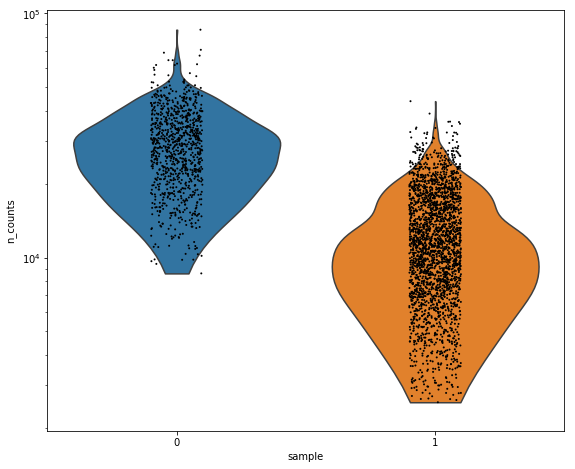

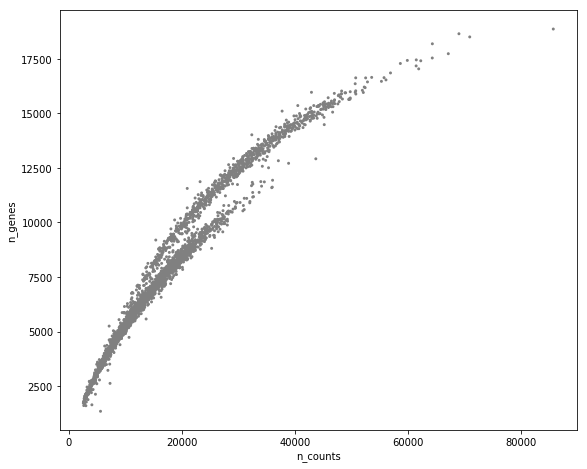

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


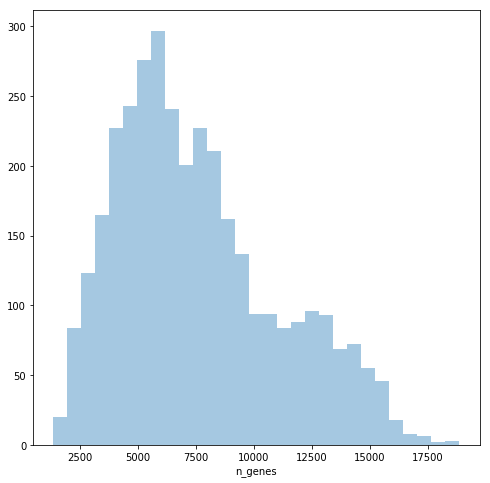

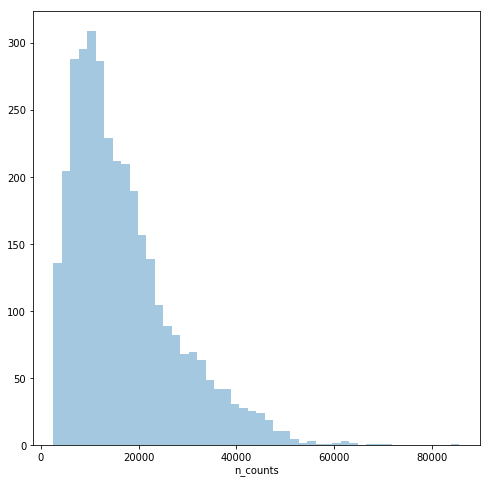

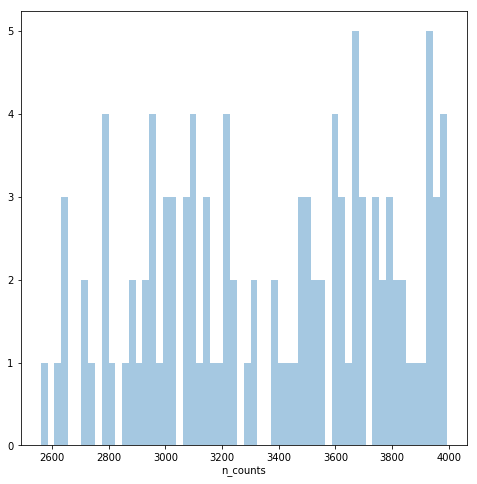

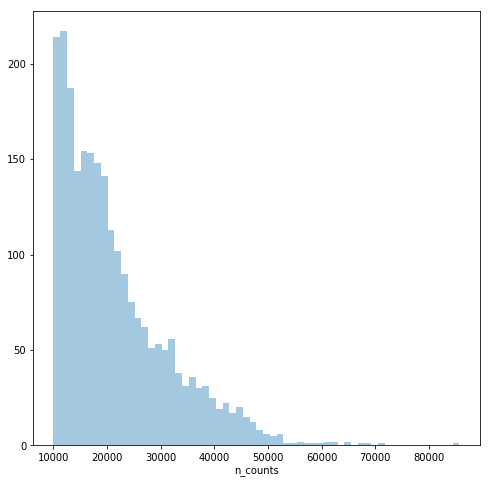

In [12]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)

p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes')

p3 = sb.distplot(adata.obs['n_genes'], kde=False)
plt.show()

p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()


The two samples likely have different qualities given the differing numbers of counts

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


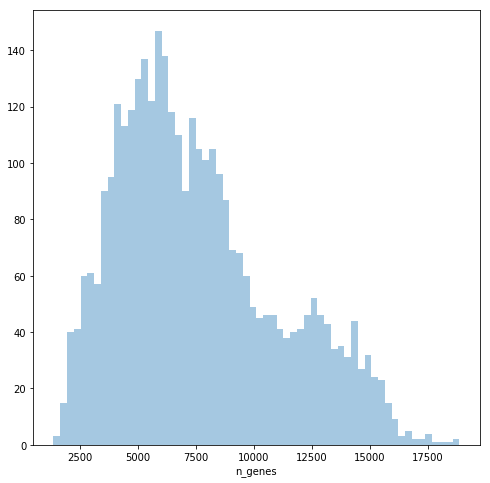

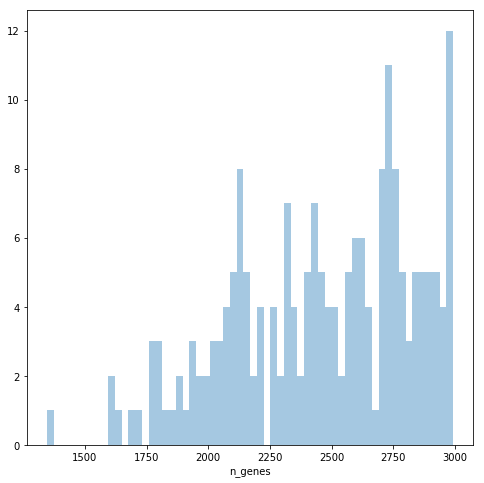

In [13]:
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<3000], kde=False, bins=60)
plt.show()

Based on the above plots we determine QC thresholds which are used to filter the cells and genes

In [14]:
##### filter 1500 genes, 3300 counts, 60k counts
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 3300)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 60000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1500)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))



Total number of cells: 3442
Number of cells after min count filter: 3392
Number of cells after max count filter: 3382
Number of cells after gene filter: 3381


In [15]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 24175
Number of genes after cell filter: 23932


# Testing denoising

Here we keep two copies of the data so that we can use one copy as a control and one copy is used with expression recovery/denoising by DCA.

In [16]:
# Keep a copy of the raw data
adata_raw = adata.copy()

In [17]:
adata_raw.obs['dropout'] = (adata_raw.X > 0).mean(1)

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


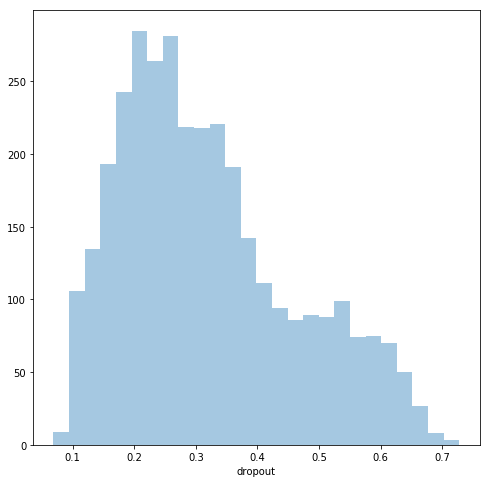

In [18]:
sb.distplot(adata_raw.obs['dropout'], kde=False)
plt.show()

There are quite high dropout rates across the cells. These rates are likely different between batches given the count distributions visualized above.

We now perform expression recovery via DCA on one of the AnnData objects.

In [19]:
sc.pp.dca(adata_raw, normalize_per_cell=False, scale=False, log1p=False, batchnorm=False)

Using TensorFlow backend.


DCA: Successfully preprocessed 23932 genes and 3381 cells.
Calculating low dimensional representations...
Calculating reconstructions...


In [20]:
adata_raw.X[:5,:5]

array([[0.7661904 , 1.3999181 , 0.85281116, 0.46276832, 1.8568145 ],
       [0.851972  , 1.6442616 , 0.9327502 , 0.47749278, 2.05012   ],
       [0.86273754, 1.6805096 , 0.94411486, 0.4753037 , 2.1211357 ],
       [0.6603831 , 1.1061972 , 0.7480817 , 0.45665464, 1.4887584 ],
       [0.519737  , 0.7477863 , 0.60171497, 0.46342713, 0.9461427 ]],
      dtype=float32)

As we can see, DCA denoising generates imputed data which is no longer count-like.

We calculate coefficients of variation on the gene expression data before and after denoising via dca.

In [21]:
gene_cov = adata.X.std(0)/adata.X.mean(0)
gene_cov_dn = adata_raw.X.std(0)/adata_raw.X.mean(0)

In [50]:
#Calculate the difference in coefficient of variation after and before denoising per gene
gene_cov_dn_diff = gene_cov_dn - gene_cov

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


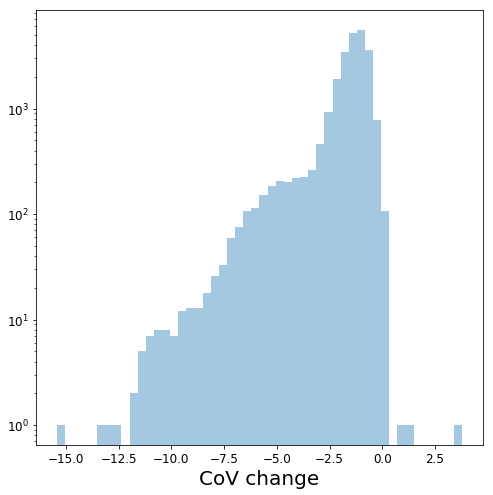

In [23]:
f1 = sb.distplot(gene_cov_dn_diff, kde=False)
f1.set_yscale('log')
f1.tick_params(labelsize=12)
f1.set_xlabel('CoV change',fontsize=20)
fig = f1.get_figure()
#fig.savefig('figures/klein_data_cov_change_denoising.png')
plt.show()

# Testing batch correction

Before testing batch correction we follow the best-practices workflow and use scran normalization, so that our results are not affected by lack of accounting for sampling depths.

In [25]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

In [26]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [27]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: scran

  warnings.warn(x, RRuntimeWarning)
/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: BiocParallel

  warnings.warn(x, RRuntimeWarning)
/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: SingleCellExperiment

  warnings.warn(x, RRuntimeWarning)
/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/rpy2/r

In [28]:
adata.obs['size_factors'] = size_factors

In [29]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

Now we again keep a copy of the non-batch-corrected data in the `adata.raw` field which we use to compare to batch corrected data later.

In [30]:
# Store the full data set in log CPM+1 for visualization and statistical testing
adata.raw = adata

In [31]:
#Calculate CoV post normalization
gene_cov_pn = adata.X.std(0)/adata.X.mean(0)

In [32]:
#Visualization
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

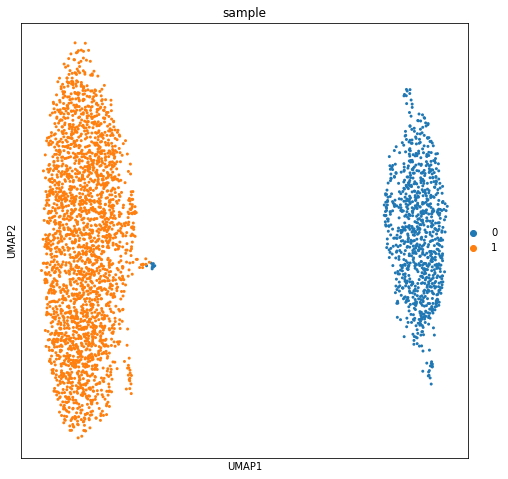

In [33]:
sc.pl.umap(adata, color='sample')#, save="_klein_sample_prebc_umap.pdf")

A large batch effect can be seen in the above plot pre-batch-correction.

In [34]:
# ComBat batch correction
data = pd.DataFrame(adata.X)
batch = pd.Series(adata.obs['sample'])
batch = batch.reset_index()
data_cor = c.combat(data=data.T, batch=batch['sample'])

found 2 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


In [35]:
#Apply the ComBat correction
adata.X = data_cor.T.values
del data_cor

In [36]:
#Visualization
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

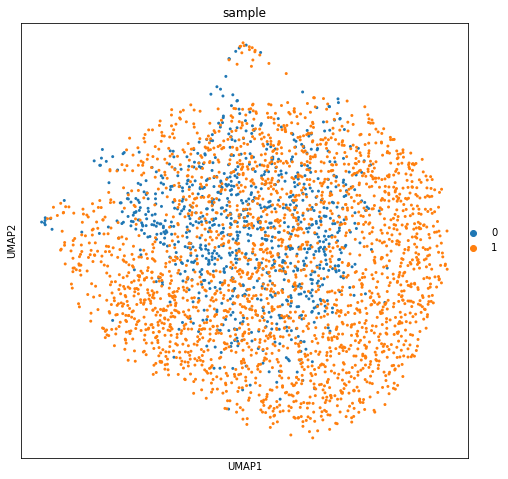

In [37]:
sc.pl.umap(adata, color='sample')#, save="_klein_sample_postbc_umap.pdf")

The batch effect has largely been removed for by ComBat. The cellular transcriptomes now overlap as expected.

In [38]:
#Calculate CoV post batch correction
gene_cov_pbc = adata.X.std(0)/adata.X.mean(0)

In [39]:
#Calculate difference in CoV pre- and post-batch-correction
gene_cov_diff = gene_cov_pbc - gene_cov_pn

In [42]:
pd.Series(gene_cov_diff).describe()

count    23932.000000
mean        -0.012637
std          0.028877
min         -1.711074
25%         -0.012393
50%         -0.005473
75%         -0.001701
max          0.002332
dtype: float64

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


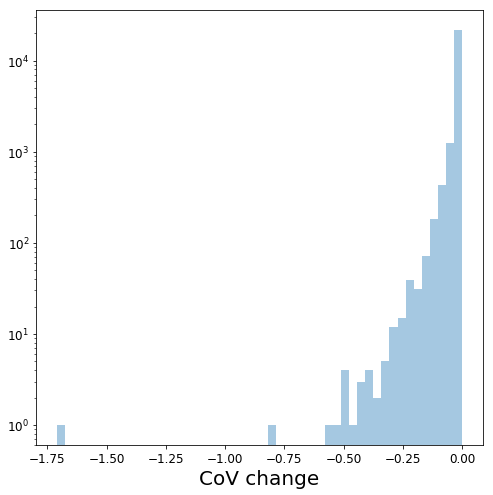

In [46]:
f1 = sb.distplot(gene_cov_diff, kde=False)
f1.set_yscale('log')
f1.tick_params(labelsize=12)
f1.set_xlabel('CoV change',fontsize=20)
fig = f1.get_figure()
#fig.savefig('figures/klein_data_cov_change_batch_correction.png')
plt.show()

In [47]:
pd.DataFrame({'dn':gene_cov_dn_diff, 'bc':gene_cov_diff}).to_csv('klein_cov_diffs.csv')